# Olly-or-not

Identify if a picture of a Springer Spaniel is Olly the dog. Provide your own pictures of Olly the dog.

# Initialisation

In [101]:
from fastai.vision.all import *
from fastai.vision.widgets import *

data_path = "data/ollyornot"

# Get data

In [33]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from time import sleep


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")


searches = [
    "springer spaniel photo",
    "springer spaniel sun photo",
    "springer spaniel shade photo",
    "springer spaniel sleep photo",
    "springer spaniel lead photo",
]
output_path = f"{data_path}/springer_spaniel"

for search in searches:
    download_images(output_path, urls=search_images(search))
    sleep(10)

Searching for 'springer spaniel photo'
Searching for 'springer spaniel sun photo'
Searching for 'springer spaniel shade photo'
Searching for 'springer spaniel sleep photo'
Searching for 'springer spaniel lead photo'


In [28]:
resize_images(f"{data_path}/springer_spaniel", max_size=400, dest=f"{data_path}/springer_spaniel")

In [51]:
failed = verify_images(get_image_files(f"{data_path}/springer_spaniel"))
print(failed)
failed.map(Path.unlink)
len(failed)

[]


0

# Create a model

In [102]:
# Create the data loaders
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(192),
    batch_tfms=aug_transforms(),
)
dls = data_block.dataloaders(data_path, bs=32)

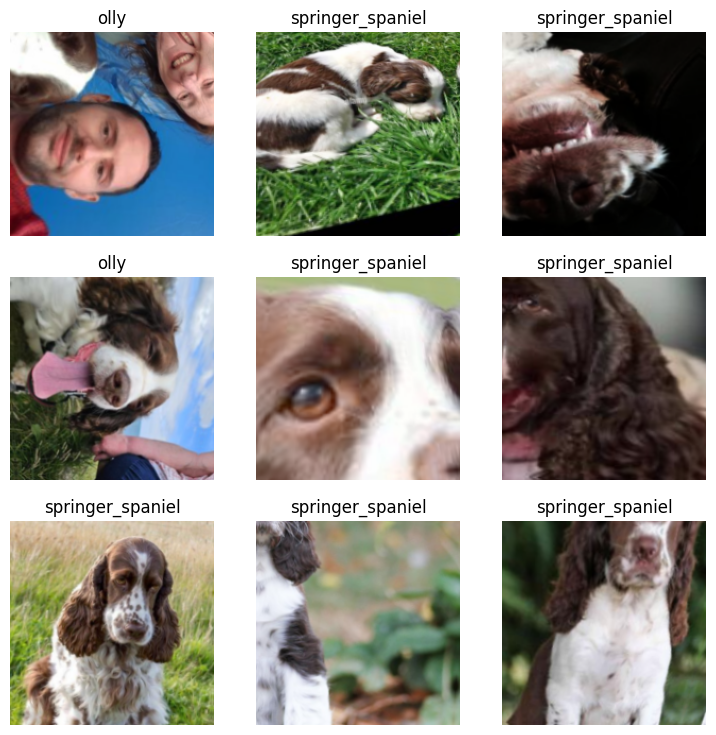

In [103]:
dls.show_batch()

In [116]:
# Run the learning
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.887458,0.581248,0.215190,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.581519,0.421756,0.202532,00:05
1,0.480287,0.492360,0.215190,00:05
2,0.393401,0.437280,0.126582,00:05
3,0.346892,0.429493,0.075949,00:05
4,0.266802,0.273644,0.050633,00:05
5,0.234532,0.375132,0.037975,00:05
6,0.197901,0.229224,0.037975,00:05
7,0.183486,0.148663,0.012658,00:05
8,0.171385,0.181983,0.025316,00:05
9,0.180903,0.719106,0.037975,00:05


# Show results

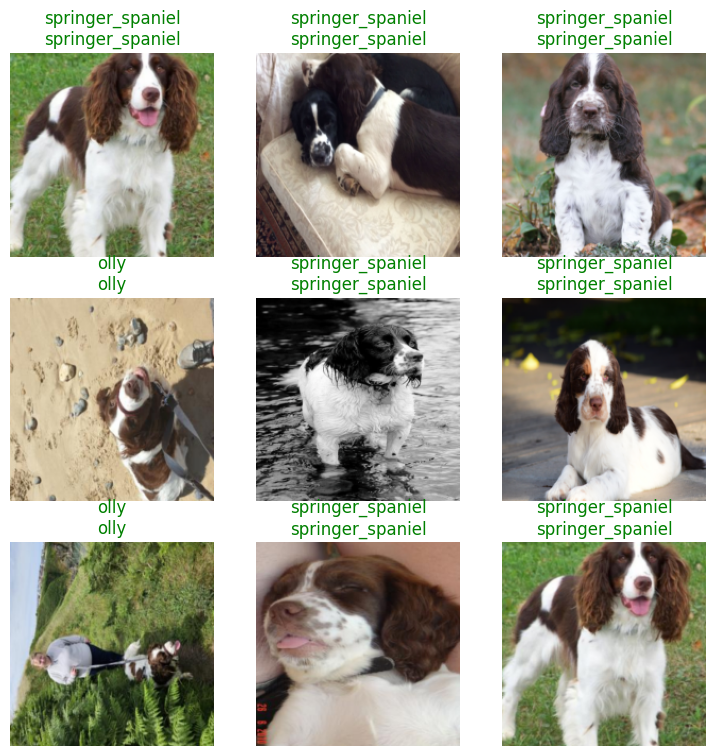

In [149]:
learn.show_results()

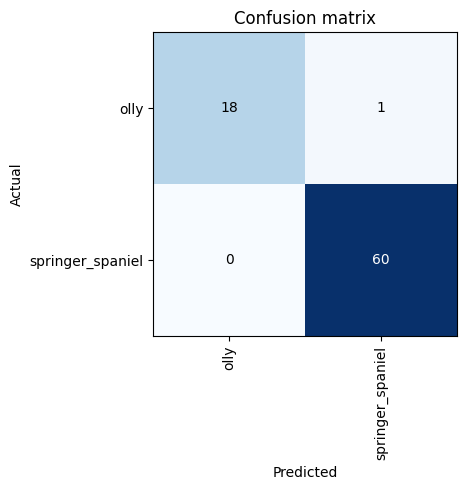

In [117]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

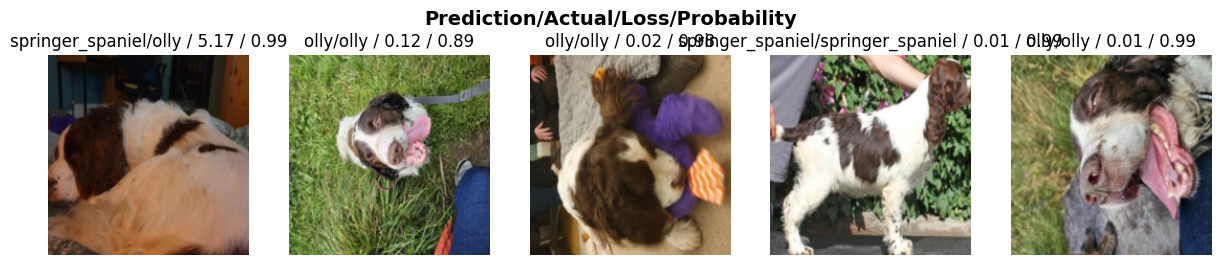

In [121]:
interp.plot_top_losses(5, nrows=1)

# Save the model

In [122]:
learn.export("models/ollyornot.pkl")

# Use in a GUI

In [150]:
import gradio as gr
from fastai.vision.all import *

categories = ("Olly", "Some other Springer")
learner = load_learner("models/ollyornot.pkl")


def classify_img(img):
    try:
        pred, pred_idx, probs = learner.predict(img)
        res = dict(zip(categories, map(float, probs)))
        return res
    except:
        return "Error"


image = gr.components.Image(shape=(400, 400))
label = gr.components.Label()

iface = gr.Interface(
    title="Olly or not",
    description="Tells you if a Springer Spaniel is Olly the Dog.",
    allow_flagging="never",
    theme=gr.themes.Monochrome(),
    fn=classify_img,
    inputs=image,
    outputs=label,
)
iface.launch()

Running on local URL:  http://127.0.0.1:7907

To create a public link, set `share=True` in `launch()`.
